<a href="https://colab.research.google.com/github/marymuthee/image_segmentation_Felzenszwalb-/blob/main/Image_segementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION

Object-based image analysis (OBIA) begins by dividing an image into homogeneous regions or “segments” that correspond to real-world features such as vegetation patches, water bodies, or built-up areas.
Unlike pixel-based classification, segmentation groups neighboring pixels with similar spectral, spatial, and textural properties into larger, meaningful objects.
These objects then serve as analysis units for further classification or statistics.

In this notebook, we reproduce in Python the multiresolution segmentation  previously performed in eCognition.
The workflow includes:

1. Loading a six-band Sentinel-2 subset (B, G, R, NIR, MIR1, MIR2).

2. Applying eCognition-style layer weights to emphasize the NIR and MIR bands.

3. Normalizing each band for balanced spectral ranges.

4. Performing segmentation using the Felzenszwalb graph-based algorithm implemented in scikit-image.

5. Visualizing the results



---
## The Felzenszwalb Algorithm (Graph-Based Segmentation)

The **Felzenszwalb–Huttenlocher (2004)** algorithm is a **graph-based image segmentation** technique that merges neighboring pixels into larger, homogeneous regions based on spectral similarity.  
It is efficient, unsupervised, and particularly well-suited for high-resolution multispectral data.

### How the Algorithm Works

1. **Graph Construction** – Each pixel is treated as a *node*, and edges connect neighboring pixels.  
   The **edge weight** represents the spectral difference between connected pixels.

2. **Edge Sorting** – All edges are sorted from most to least similar, ensuring merging begins with the most spectrally alike pixels.

3. **Region Merging** – Initially, each pixel is its own region.  
   Neighboring regions are merged if their difference is smaller than a local, adaptive threshold.

4. **Adaptive Thresholding** – The threshold depends on internal variability and the global *scale* parameter.  
   - Uniform regions (like water) merge easily  
   - Heterogeneous areas (like built-up zones) resist merging

5. **Post-Processing** – Very small regions (below `min_size`) are merged with their most similar neighbor, cleaning up the segmentation.

---

## Key Parameters

| Parameter | Controls | Effect when increased |
|------------|-----------|-----------------------|
| `scale` | Maximum allowed dissimilarity between merged regions | Produces **larger, smoother** segments |
| `sigma` | Gaussian smoothing before segmentation | Reduces tonal variation; merges smoother areas (useful for lakes/water) |
| `min_size` | Minimum allowed object size (pixels) | Removes small patches; creates cleaner objects |

---

## Why This Algorithm

- Conceptually similar to **eCognition’s Multiresolution Segmentation**
- Flexible control over object size and smoothness (`scale`, `sigma`, `min_size`)
- **Unsupervised** – no training data required  
- **Computationally efficient** for medium to large imagery  
- Preserves **object boundaries**, critical for distinguishing vegetation, water, and built-up areas

---

## Reference
Felzenszwalb, P. F., & Huttenlocher, D. P. (2004).  
*Efficient graph-based image segmentation.*  
**International Journal of Computer Vision**, 59(2), 167–181.


# Load Packages

In [3]:
#installing packages
!pip install rasterio geopandas shapely fiona pyproj scikit-image matplotlib tqdm --quiet

In [7]:
#import the libraries

# --- Core Python libraries ---
import os                               # For handling file paths, directories, and saving outputs
import numpy as np                      # For numerical and array operations on image data
import matplotlib.pyplot as plt         # For plotting and visualizing images and segmentation boundaries

# --- Raster handling and processing ---
import rasterio                         # To read/write raster (GeoTIFF) data while preserving georeferencing
from rasterio.plot import reshape_as_image  # Converts (bands, rows, cols) arrays to (rows, cols, bands) for visualization
from rasterio.features import shapes        # Extracts vector polygons from raster segment labels (vectorization)

# --- Vector / geometry libraries ---
from shapely.geometry import shape      # Creates geometric objects (polygons) from raster features
import geopandas as gpd                 # For working with and exporting vector data (GeoDataFrames, shapefiles, GeoJSON)

# --- Image segmentation (computer vision) ---
from skimage.segmentation import felzenszwalb, mark_boundaries
# felzenszwalb → performs region-based image segmentation (similar to multiresolution in eCognition)
# mark_boundaries → draws visible outlines of segments over an image for visualization

# --- Progress visualization ---
from tqdm import tqdm                   # Displays progress bars for loops (e.g., while converting raster → polygons)


# Import Data

In [11]:
#defining the data path (from my github)
img_path = "https://github.com/marymuthee/datasets/raw/main/Sentinel2A_subset_bands_BGRNir4MIR1MIR2.tif"

#opening te raster file
src=rasterio.open(img_path)

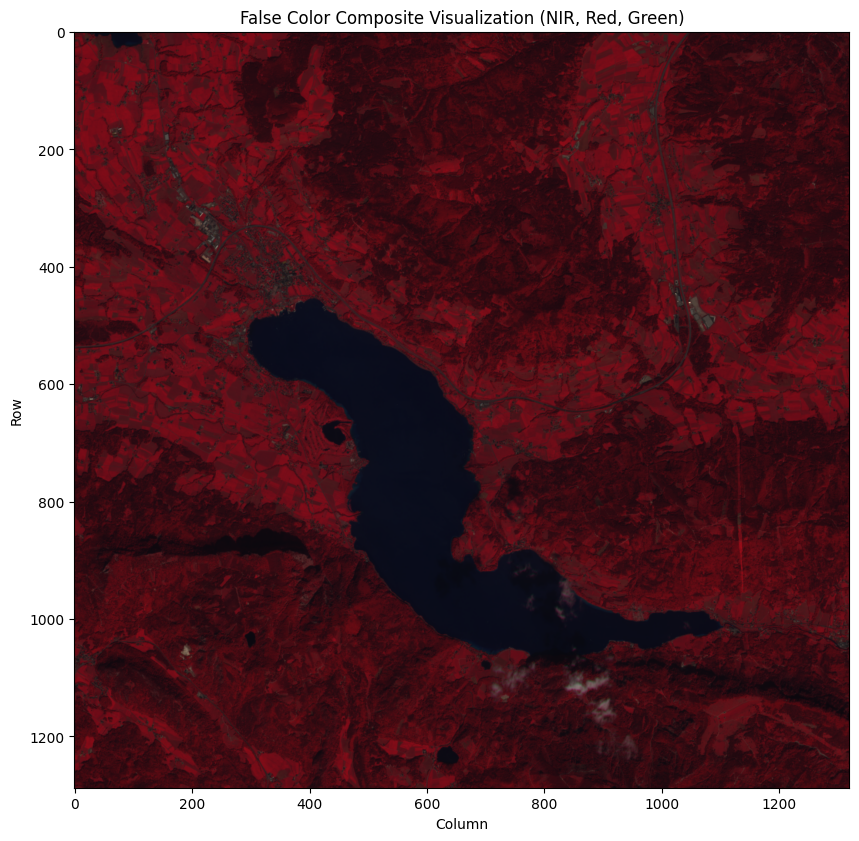

In [19]:
# Convert the raster data to an image format suitable for visualization
img = reshape_as_image(src.read())

#create a false color compsite from the image (3,2,1)
img_false_color = img[:, :, [3, 2, 1]]
# To make the plot brighter, we can adjust the display range (vmin and vmax)
# Let's use the min and max values of the selected bands for a basic stretch
vmin = img_false_color.min()
vmax = img_false_color.max()

# Display the false color composite image
plt.figure(figsize=(10, 10))
plt.imshow(img_false_color, vmin=vmin, vmax=vmax)
plt.title('False Color Composite Visualization (NIR, Red, Green)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

# Weighting

In [20]:
#read the bands from image to an array
arr = src.read().astype("float32")   # shape: (bands, H, W)
print("Bands, H, W:", arr.shape)

Bands, H, W: (6, 1288, 1320)


In [23]:
import numpy as np

#define the layers weight (as used in ecognition)
weights = np.array([1, 1, 1, 3, 3, 3], dtype=np.float32)  # B, G, R, NIR, MIR1, MIR2

#check if the 6 bands are there
assert arr.shape[0] == 6, "Expected 6 bands (B,G,R,NIR,MIR1,MIR2)."

arr_w = arr * weights[:, None, None]

#check the mean weights before and after wighting fro each band
print("Weights used:", weights.tolist())
print("Per-band mean BEFORE weighting:", [float(arr[i].mean()) for i in range(6)])
print("Per-band mean AFTER  weighting:", [float(arr_w[i].mean()) for i in range(6)])

Weights used: [1.0, 1.0, 1.0, 3.0, 3.0, 3.0]
Per-band mean BEFORE weighting: [23.399065017700195, 21.110137939453125, 13.285140037536621, 63.721519470214844, 32.41901397705078, 16.29985237121582]
Per-band mean AFTER  weighting: [23.399065017700195, 21.110137939453125, 13.285140037536621, 191.16465759277344, 97.25702667236328, 48.8995475769043]


# Bands Normalization

In [24]:
#create an emptry array, same size as teh previous one
#important for storing the normalized bands as numpy array
arr_w_norm = np.empty_like(arr_w, dtype=np.float32)

#create a loop
#loops through each of the 6 bands
for i in range(arr_w.shape[0]):
    a = arr_w[i]
    p2, p98 = np.nanpercentile(a, [2, 98])   # robust stretch limits #remove outliers
    denom = max(p98 - p2, 1e-6)              # avoid divide-by-zero
    arr_w_norm[i] = np.clip((a - p2) / denom, 0, 1)

print("Normalized array shape:", arr_w_norm.shape)


Normalized array shape: (6, 1288, 1320)


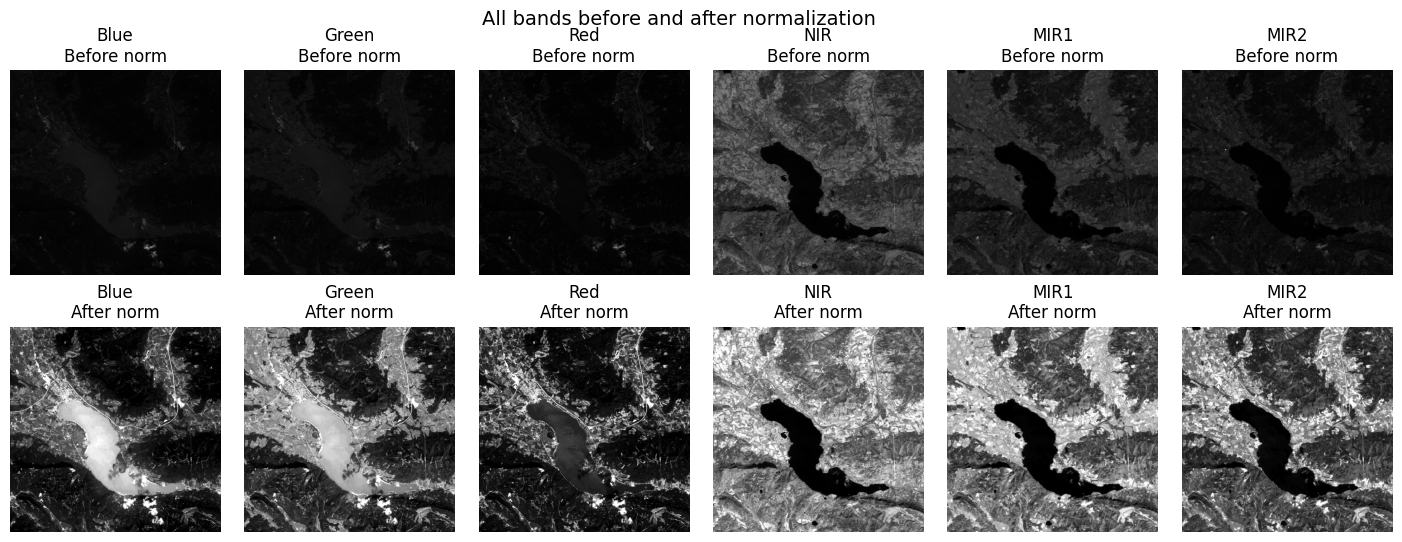

In [26]:

#visually inspect all bands before and after normalization
import matplotlib.pyplot as plt

band_names = ["Blue", "Green", "Red", "NIR", "MIR1", "MIR2"]

fig, axes = plt.subplots(2, 6, figsize=(18,6))
plt.subplots_adjust(wspace=0.05, hspace=0.25)

for i in range(6):
    # --- Top row: before normalization ---
    axes[0, i].imshow(arr_w[i], cmap='gray')
    axes[0, i].set_title(f"{band_names[i]}\nBefore norm")
    axes[0, i].axis('off')

    # --- Bottom row: after normalization ---
    axes[1, i].imshow(arr_w_norm[i], cmap='gray')
    axes[1, i].set_title(f"{band_names[i]}\nAfter norm")
    axes[1, i].axis('off')

plt.suptitle("All bands before and after normalization", fontsize=14)
plt.show()



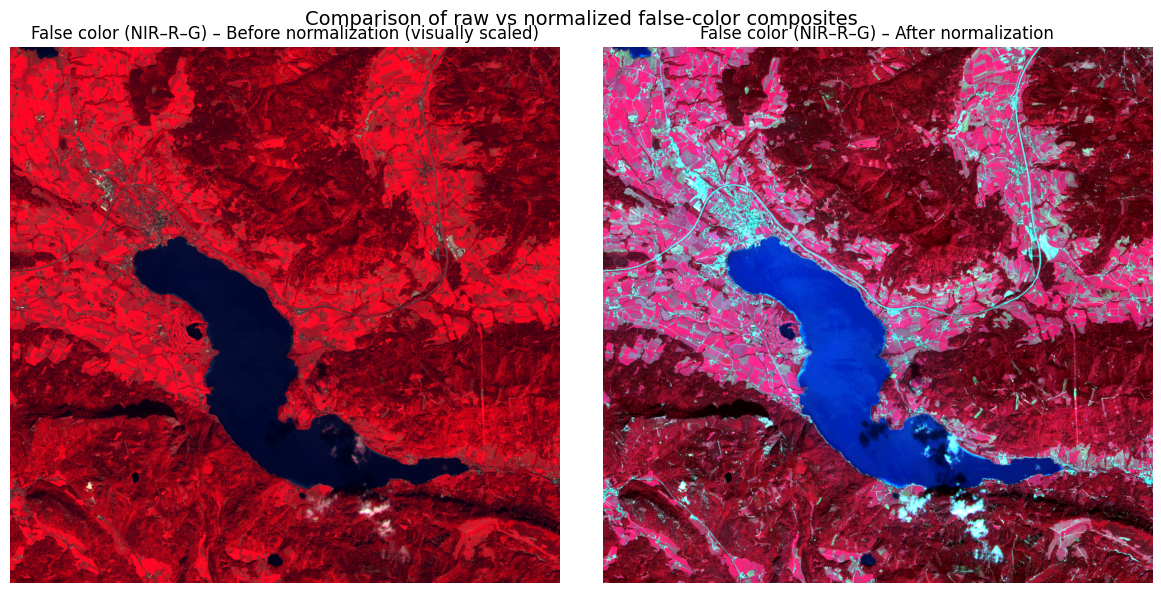

In [32]:
#call libraries
import numpy as np
import matplotlib.pyplot as plt

# Function to normalize and clip for display (stretching the raw image)
def normalize_for_display(array):
    arr_min, arr_max = np.percentile(array, (2, 98))
    arr_norm = (array - arr_min) / (arr_max - arr_min + 1e-6)
    return np.clip(arr_norm, 0, 1)   # explicitly clip within [0,1]

# Recreate composites
#pick the false color composite from bot the raw and normalize images
#give a consisten float type
disp_raw = np.dstack([arr[3], arr[2], arr[1]]).astype(np.float32)
disp_norm = np.dstack([arr_w_norm[3], arr_w_norm[2], arr_w_norm[1]]).astype(np.float32)

# Normalize raw for display only
disp_raw_vis = normalize_for_display(disp_raw)
disp_norm_vis = np.clip(disp_norm, 0, 1)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12,6)) #creates a fig with 1 row and 2 columns
#raw image
axes[0].imshow(disp_raw_vis)
axes[0].set_title("False color (NIR–R–G) – Before normalization (visually scaled)")
axes[0].axis("off") #hide axis

#normalize image
axes[1].imshow(disp_norm_vis)
axes[1].set_title("False color (NIR–R–G) – After normalization")
axes[1].axis("off") #hide axis

plt.suptitle("Comparison of raw vs normalized false-color composites", fontsize=14)
plt.tight_layout()
plt.show()


# Segmentation

In [107]:
#import the segmanetation method from scikit-image
from skimage.segmentation import felzenszwalb
SEG_SCALE   = 180  #Controls the maximum allowed heterogeneity within each segment.
SEG_SIGMA   = 1.2 #smoothing -reduces over-segmentation.
SEG_MINSIZE = 3200  #Removes tiny fragments by merging them into neighbors.

#perform the segmanetation process
segments= felzenszwalb(
    reshape_as_image(arr_w_norm),
    scale=SEG_SCALE,
    sigma=SEG_SIGMA,
    min_size=SEG_MINSIZE
)

#pint the number of segements that were generated
print("Unique segments:", np.unique(segments).size)


/tmp/ipython-input-2665613272.py:8: RuntimeWarning: Got image with third dimension of 6. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments= felzenszwalb(


Unique segments: 98


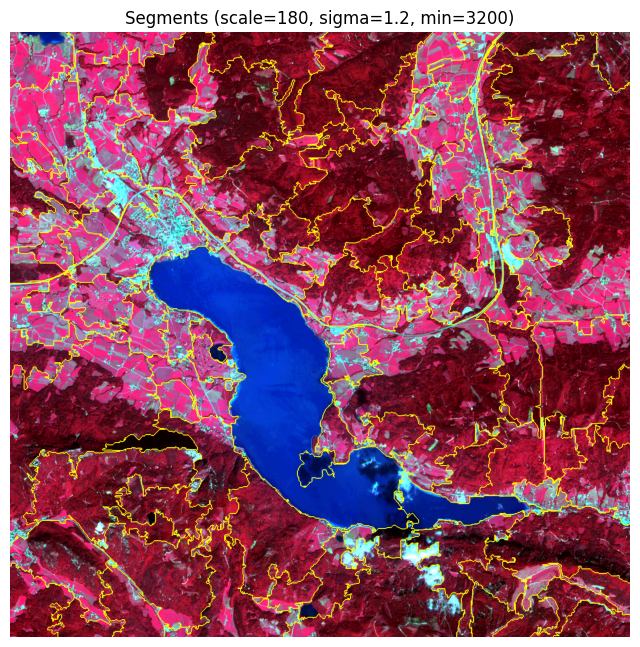

In [110]:
#import the mark_boundariesN(shows segmentation outlines)
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt #for plotting

#create a false color compsite for overlaying the segements
disp = np.dstack([arr_w_norm[3], arr_w_norm[2], arr_w_norm[1]])  # NIR-R-G

#plot fiure size
plt.figure(figsize=(8,8))
#plot the false color image and the segments generated #make the outline  thick too
plt.imshow(mark_boundaries(disp, segments, mode="thick"))

#title gets the used scale, sigma and miniize
plt.title(f"Segments (scale={SEG_SCALE}, sigma={SEG_SIGMA}, min={SEG_MINSIZE})")
plt.axis("off")
plt.show()